# Averaged Artifact Substraction with EEG Data
## First step prepare Jupyter Notebook

In [1]:
import os
from FACET.Facet import Facet
from loguru import logger
import sys

os.getcwd()
os.chdir(os.path.dirname(os.path.abspath("__file__")))

eegDataSet_filepath = "NiazyFMRI.edf"
motiondata_moosmann_filepath = "headmotiondata.tsv"
export_bids_path = "./bids_dir"

#configure logging
logger.remove()
logger.add(sys.stderr, level="INFO")
logger.add("Facet.log", level="DEBUG")

#defining important parameters
window_size = 30 # defines the window size for averaging
upsampling_factor = 10 # defines the resampling factor
artifact_to_trigger_offset_seconds = -0.005 # defines the artifact position in seconds relative to the triggermark.
relative_window_position = -0.5 # defines the relative position of the averaging window over the epochs.
event_id_description_pairs={'trigger':1} # For exporting as bids. It defines the event id and its description.
regex_trigger_annotation_filter = r'\b1\b' # r'\btrigger\b' # Annotations with the description 'trigger' are considered as triggers, declard for find triggers after reimporting from bids
regex_trigger_event_filter = r'\b1\b' # Events with the value 1 are considered as triggers, declared for edf stim channel
unwanted_bad_channels = ['EKG', 'EMG', 'EOG', 'ECG'] # Channels with these names are considered as bad channels and not considered in the processing
evaluation_measures=["SNR", "RMS", "RMS2", "MEDIAN"] # Measures that must be calculated and used for evaluation.

f = Facet()


## Second Step import EEG Data

In [2]:
f.import_EEG(eegDataSet_filepath, artifact_to_trigger_offset=artifact_to_trigger_offset_seconds, upsampling_factor=upsampling_factor, bads=unwanted_bad_channels)
#Uncomment if you wanna reload as bids. Pro: Annotations will be loaded for better visualization. Cons: Somehow the SNR has a lower value.
#f.export_EEG(path="./export",fmt="bids", event_id=event_id_description_pairs)
#f.import_EEG(path="./export",fmt="bids", artifact_to_trigger_offset=artifact_to_trigger_offset_seconds, bads=unwanted_bad_channels)
f.plot_EEG(title="after import")

2024-03-28 11:34:33.207 | INFO     | FACET.Facet:import_EEG:18 - Importing EEG from NiazyFMRI.edf


## Third Step Preprocessing

In [3]:
f.get_EEG().mne_raw.crop(0,162) # cropping the data for the niazy dataset, because the edf has bad data at the end
f.pre_processing()


2024-03-28 11:34:35.130 | INFO     | FACET.Frameworks.Correction:upsample:598 - Upsampling Data


## Fourth Step find triggers

In [4]:

f.find_triggers(regex_trigger_annotation_filter) # Using Niazys data
f.align_triggers(0) # Aligning the triggers to the first trigger
f.get_analysis().print_analytics()

2024-03-28 11:34:46.231 | INFO     | FACET.Facet:find_triggers:26 - finding triggers
2024-03-28 11:34:46.294 | INFO     | FACET.Facet:find_triggers:29 - Found 840 triggers
2024-03-28 11:34:47.739 | INFO     | FACET.Frameworks.Analysis:print_analytics:322 - Analysis:
2024-03-28 11:34:47.741 | INFO     | FACET.Frameworks.Analysis:print_analytics:323 - Number of Triggers found: 840
2024-03-28 11:34:47.742 | INFO     | FACET.Frameworks.Analysis:print_analytics:324 - Art Length: 2922
2024-03-28 11:34:47.743 | INFO     | FACET.Frameworks.Analysis:print_analytics:325 - Duration of Art in seconds: 0.14267578125
2024-03-28 11:34:47.751 | INFO     | FACET.Frameworks.Analysis:print_analytics:332 - Time Start: 0.0 s
2024-03-28 11:34:47.759 | INFO     | FACET.Frameworks.Analysis:print_analytics:333 - Time End: 162.000439453125 s
2024-03-28 11:34:47.761 | INFO     | FACET.Frameworks.Analysis:print_analytics:334 - Sampling Frequency: 20480.0 Hz
2024-03-28 11:34:47.762 | INFO     | FACET.Frameworks.An

## Fourth step apply AAS

In [5]:
f.calc_matrix_AAS(window_size=window_size, rel_window_position=relative_window_position)

2024-03-28 11:34:47.775 | INFO     | FACET.Facet:calc_matrix_AAS:33 - Applying AAS with method numpy


## Fifth step Remove Artifacts

In [6]:
f.remove_artifacts( )


## Sixth step Post-Processing

In [7]:
f.post_processing()

2024-03-28 11:34:58.932 | INFO     | FACET.Frameworks.Correction:downsample:587 - Downsampling Data


## Seventh display the processed eeg data

In [8]:
f.plot_EEG(title="after lowpass")

## Eighth Evaluate Results

2024-03-28 11:35:05.165 | INFO     | FACET.Facet:add_to_evaluate:76 - Adding to evaluation...
2024-03-28 11:35:05.373 | INFO     | FACET.Facet:evaluate:79 - Evaluating...


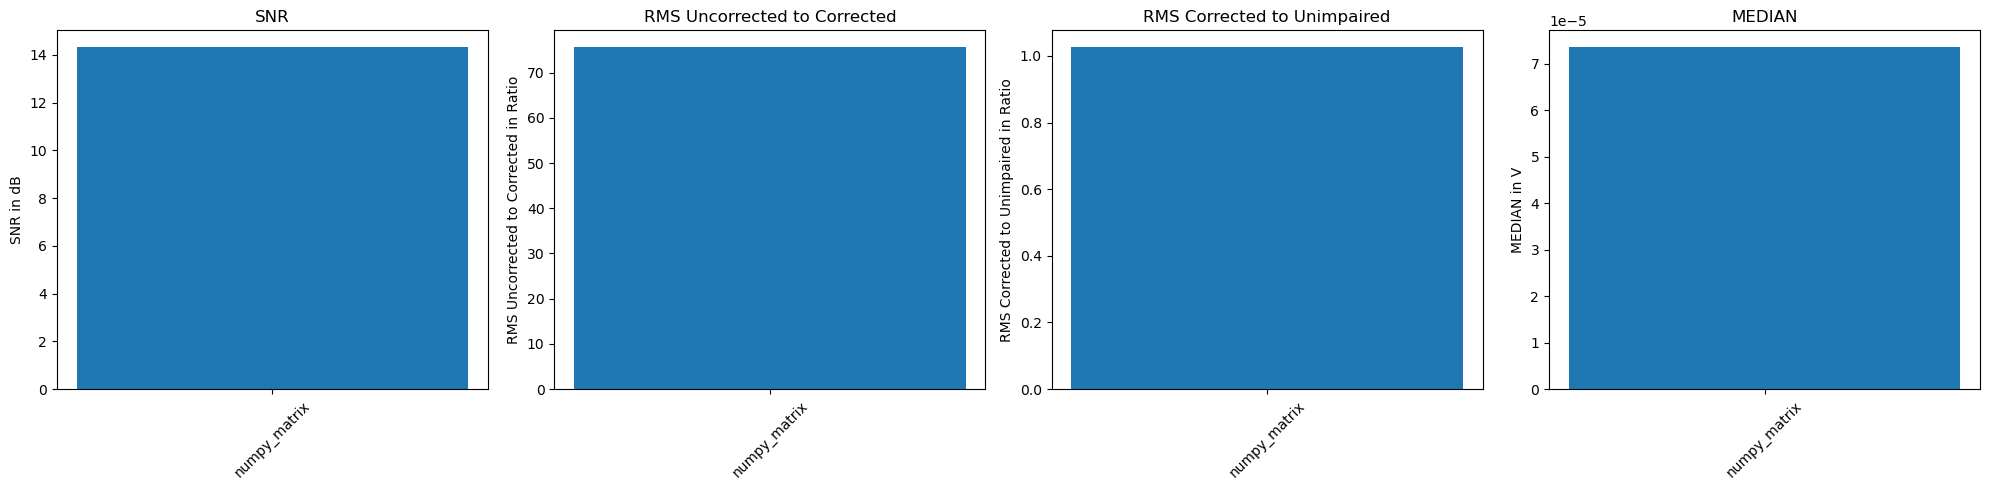

2024-03-28 11:35:06.291 | INFO     | __main__:<module>:3 - [{'Measure': 'SNR', 'Values': [14.30663009193633], 'Unit': 'dB'}, {'Measure': 'RMS Uncorrected to Corrected', 'Values': [75.56580247690306], 'Unit': 'Ratio'}, {'Measure': 'RMS Corrected to Unimpaired', 'Values': [1.025352689240672], 'Unit': 'Ratio'}, {'Measure': 'MEDIAN', 'Values': [7.347684058367845e-05], 'Unit': 'V'}]
2024-03-28 11:35:06.293 | INFO     | FACET.Frameworks.Analysis:export_EEG:90 - Exporting Channels: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2', 'AF4', 'AF3', 'FC2', 'FC1', 'CP1', 'CP2', 'PO3', 'PO4', 'FC6', 'FC5', 'CP5', 'EMG', 'ECG', 'Status']


: 

In [9]:
eeg_python = f.get_EEG()
f.add_to_evaluate(eeg_python, name="numpy_matrix") # Matrix will result in >1.0 RMS2 because of python mne inaccuracies
logger.info(f.evaluate(measures=evaluation_measures))
f.export_EEG(event_id=event_id_description_pairs, path=export_bids_path, fmt="bids")

